In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



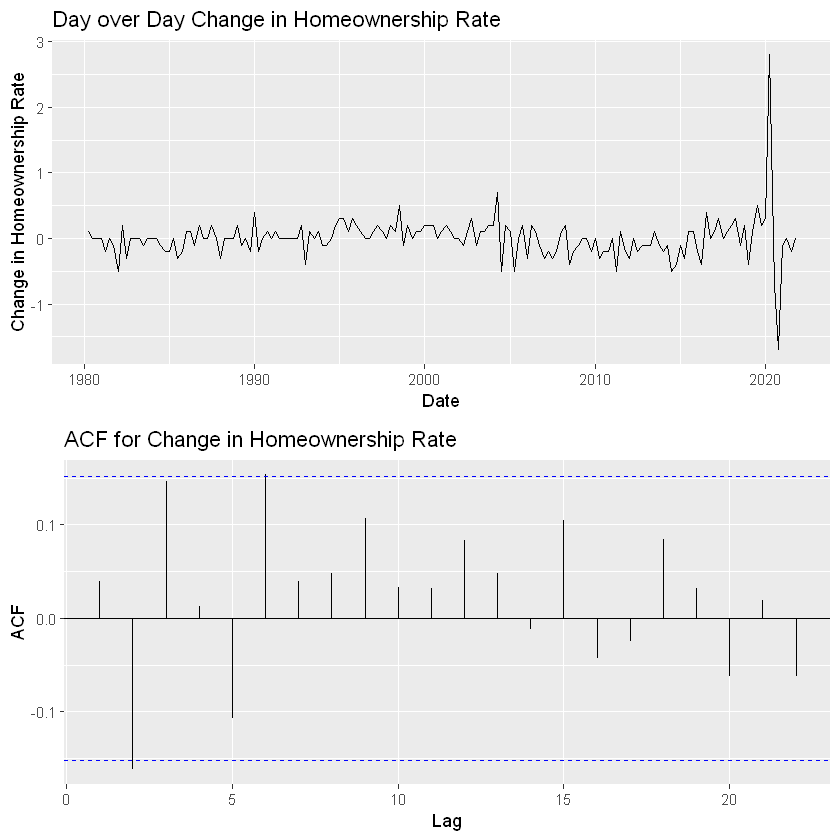

In [2]:
homeownership <- read_homeownership()
diff_homeownership <- homeownership %>% mutate(dValue = Value - lag(Value)) %>% drop_na %>% select(-Value)

p1 <- diff_homeownership %>% ggplot() +
    geom_line(aes(x = Date, y = dValue)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(diff_homeownership$dValue) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

In [3]:
outliers <- tsoutliers(homeownership$Value)
outliers
cleaned_homeownership <- homeownership
cleaned_homeownership$Value[outliers$index] <- outliers$replacements

$index
[1] 162 163

$replacements
[1] 65.43333 65.56667

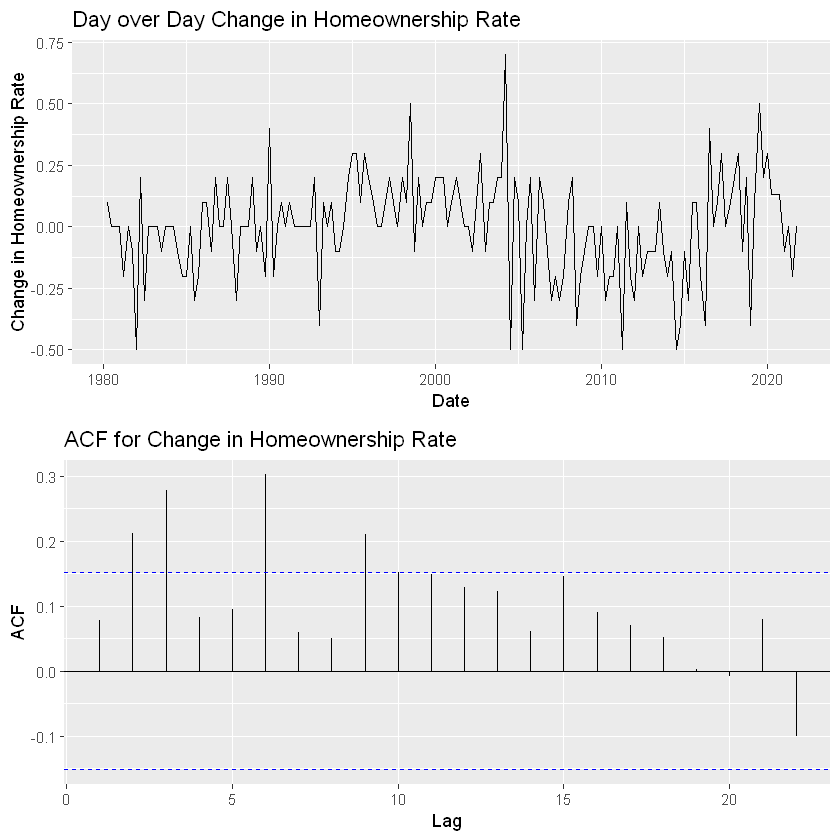

In [4]:
diff_homeownership <- cleaned_homeownership %>% mutate(dValue = Value - lag(Value)) %>% drop_na %>% select(-Value)

p1 <- diff_homeownership %>% ggplot() +
    geom_line(aes(x = Date, y = dValue)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(diff_homeownership$dValue) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

In [5]:
train <- head(diff_homeownership, -4)
test <- tail(diff_homeownership, 4)
arima_fit <- fit_arima(training_data = train$dValue, p_range = 0:5, d_range = 0:2, q_range = 0:5)
head(arima_fit)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,0,5,-74.22841
2,5,0,4,-74.22443
3,5,0,5,-72.88704
4,3,0,3,-71.75546
5,2,1,3,-70.07758
6,3,0,4,-69.52296



	Box-Ljung test

data:  residuals(model)
X-squared = 2.3693, df = 1, p-value = 0.1237


	Box-Ljung test

data:  residuals(model)^2
X-squared = 9.4931, df = 1, p-value = 0.002062



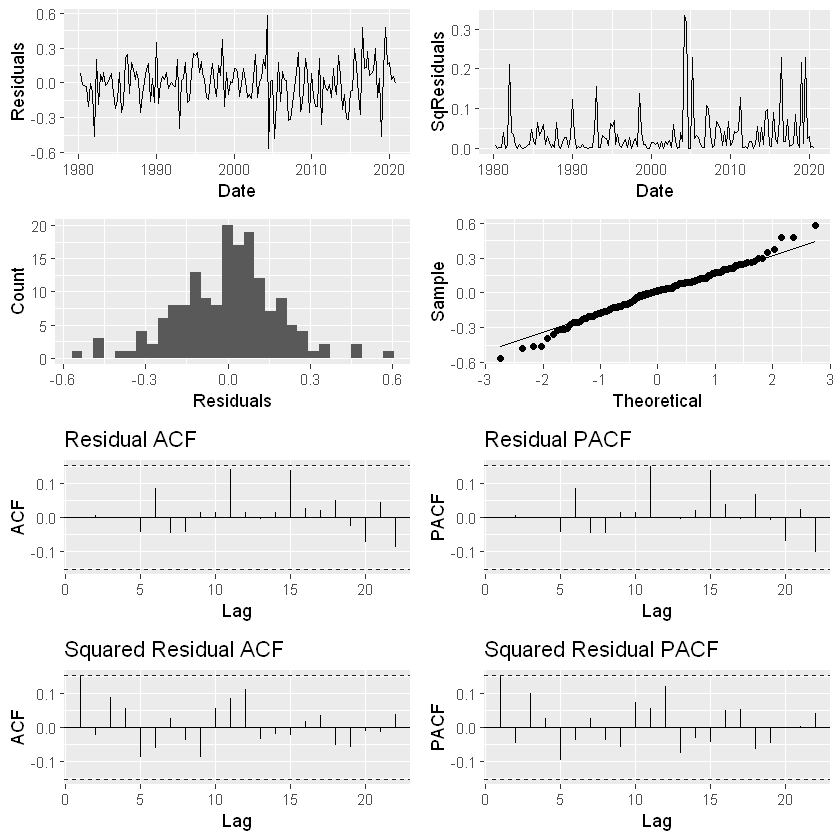

In [13]:
suppressWarnings(arima_model <- arima(train$dValue, order = c(4,0,5), method = "ML"))
residual_analysis(arima_model, train$Date)
box_tests(arima_model, 9)

In [7]:
arma_garch_fit <- fit_ugarch(train$dValue, 3, 3, 0:5, 0:5, 0:2, 0:2)
head(arma_garch_fit$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,5,2,1,0,-0.3443818
2,5,2,2,0,-0.3002075
3,5,2,0,0,-0.2790498
4,5,2,0,1,-0.2786436
5,5,2,1,1,-0.2548126
6,5,2,2,2,-0.2060961



	Box-Ljung test

data:  residuals(model)
X-squared = 15.855, df = 1, p-value = 6.838e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 11.343, df = 1, p-value = 0.0007575



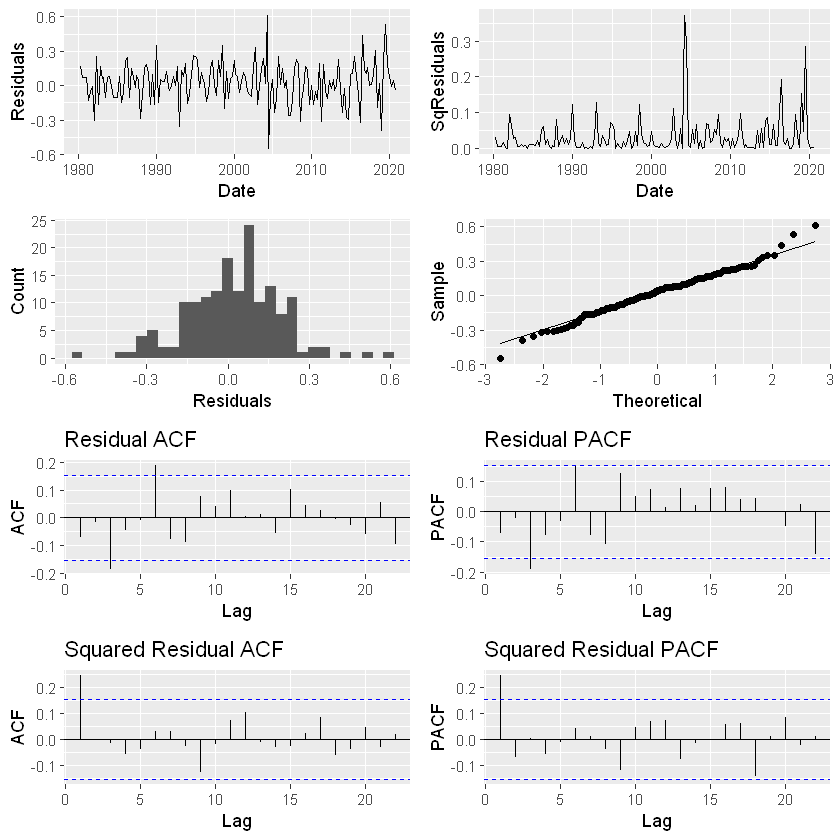

In [8]:
spec <- ugarchspec(variance.model=list(garchOrder=c(1,0)),
                     mean.model=list(armaOrder=c(5,2),
                                     include.mean=T), distribution.model="std")
suppressWarnings(ugarch_model1 <- ugarchfit(spec, train$dValue, solver = 'hybrid'))
residual_analysis(ugarch_model1, train$Date)
box_tests(ugarch_model1, 8)


	Box-Ljung test

data:  residuals(model)
X-squared = 16.91, df = 1, p-value = 3.919e-05


	Box-Ljung test

data:  residuals(model)^2
X-squared = 14.118, df = 1, p-value = 0.0001717



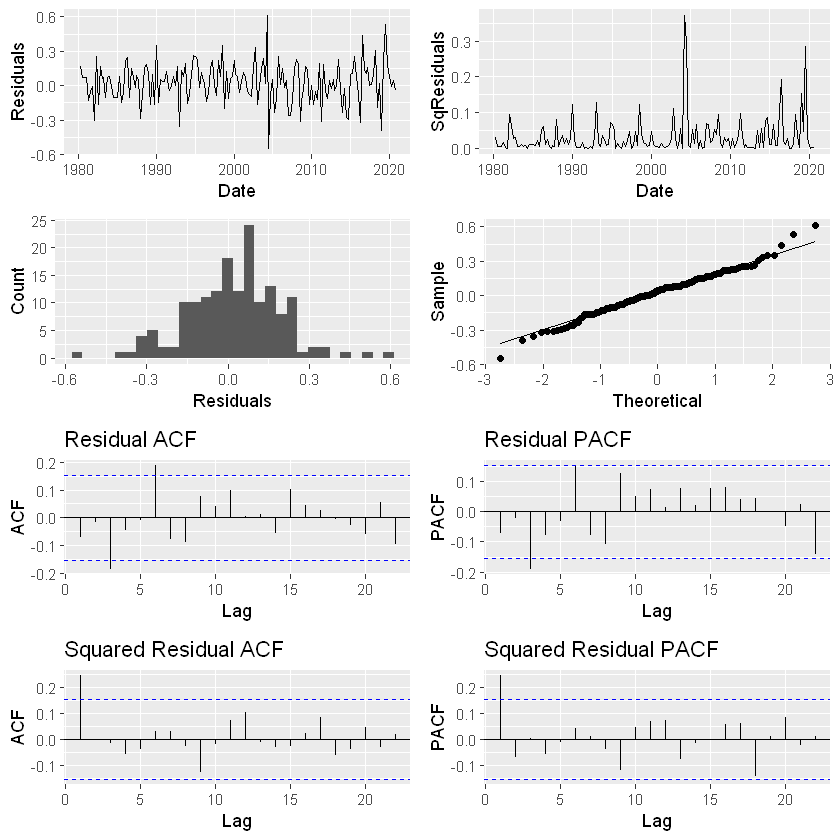

In [9]:
spec <- ugarchspec(variance.model=list(garchOrder=c(1,1)),
                     mean.model=list(armaOrder=c(5,2),
                                     include.mean=T), distribution.model="std")
suppressWarnings(ugarch_model2 <- ugarchfit(spec, train$dValue, solver = 'hybrid'))
residual_analysis(ugarch_model1, train$Date)
box_tests(ugarch_model1, 9)

PM =  5.719416

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1796106,0.1982952,0.1796106,-Inf,Inf


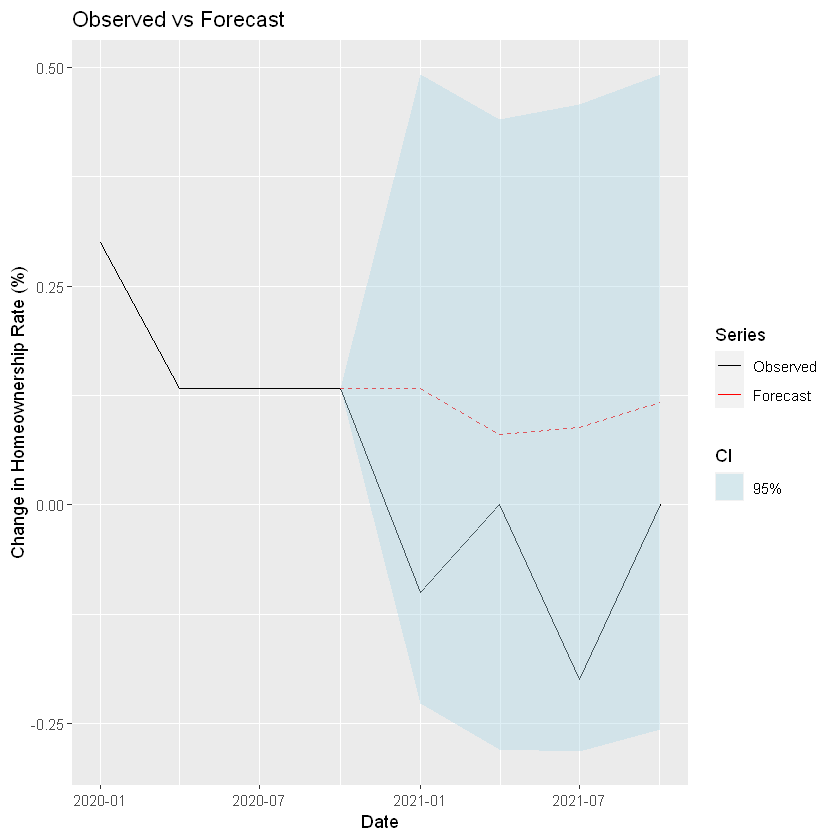

In [10]:
fc <- forecast_arima(arima_model, diff_homeownership$Date, test$dValue, 4, 95,
                    y_lab = "Change in Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  5.343674

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1537339,0.191671,0.1537339,-Inf,Inf


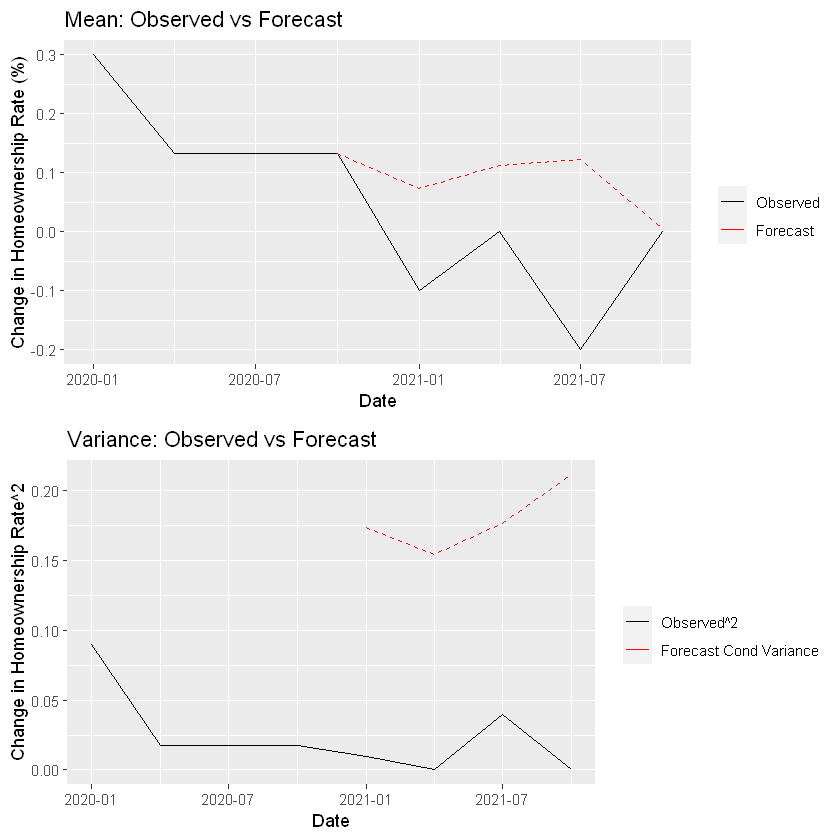

In [11]:
fc <- forecast_ugarchroll(ugarch_model1, diff_homeownership$Date, test$dValue, 4,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  5.363332

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1317166,0.1920232,0.1688564,NaN,Inf


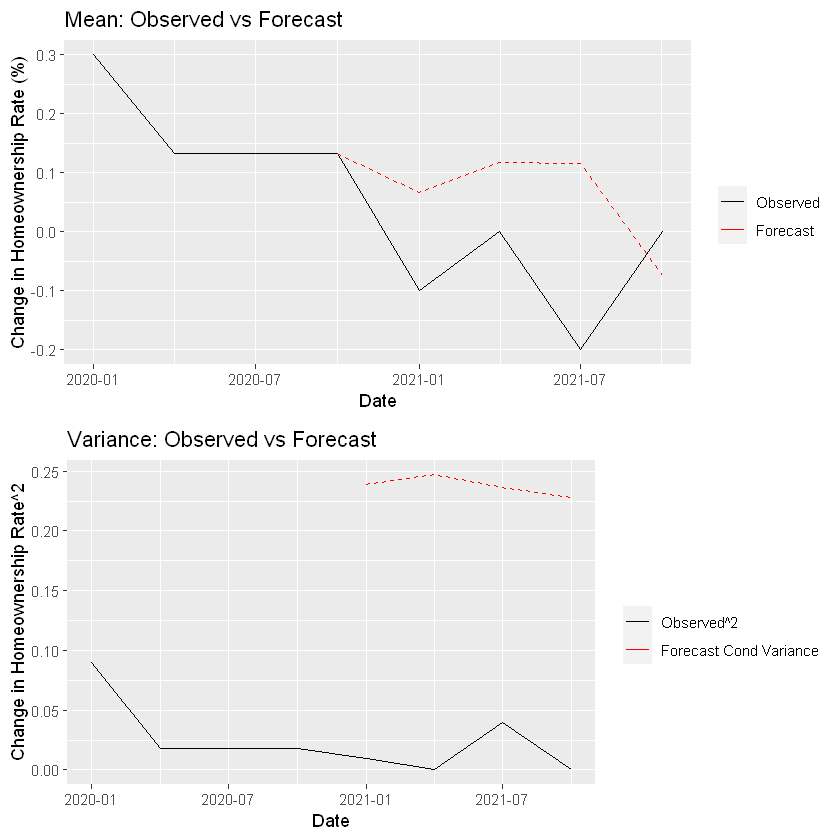

In [12]:
fc <- forecast_ugarchroll(ugarch_model2, diff_homeownership$Date, test$dValue, 4,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)